# ประเมินค่า input variables ที่ส่งผลต่อ ระบบทำความร้อนและเย็น
1. หา Important Feature โดย Random Forest, ค่าCorrelation, และค่าMutual Information
2. ใช้ Support vector machine เทียบการ Evaluation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme();

# for scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# for linear and SVM model
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, GridSearchCV, KFold
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor

import joblib
import pickle

## ข้อมูลจากแบบจำลองอาคาร 768 แบบ

    - X1 Relative Compactness ค่าทางวิศวะโยธา(ขึ้นอยู่กับรูปร่างของตึก)
    - X2 Surface Area         พื้นที่ผิวตึก
    - X3 Wall Area            พื้นที่ผนัง
    - X4 Roof Area            พื้นที่หนังคา
    - X5 Overall Height       ความสูงตึก
    - X6 Orientation          ทิศ (เหนือ,ใต้,ออก,ตก)
    - X7 Glazing Area         พื้นที่กระจก
    - X8 Glazing Area Distribution กระจายตัวของการติดตั้งกระจก
    - y1 Heating Load         พลังงงานที่ใช้ในระบบทำความร้อน
    - y2 Cooling Load         พลังงงานที่ใช้ในระบบทำความเย็น

In [2]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx'
df = pd.read_excel(url, names=['x1_compact', 'x2_surf', 'x3_wall', 'x4_roof', 'x5_height',
                               'x6_orient', 'x7_glaz', 'x8_glaz_dis', 'y1_heat', 'y2_cool'])
df

,x1_compact,x2_surf,x3_wall,x4_roof,x5_height,x6_orient,x7_glaz,x8_glaz_dis,y1_heat,y2_cool
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28
...,...,...,...,...,...,...,...,...,...,...
763,0.64,784.0,343.0,220.50,3.5,5,0.4,5,17.88,21.40
764,0.62,808.5,367.5,220.50,3.5,2,0.4,5,16.54,16.88
765,0.62,808.5,367.5,220.50,3.5,3,0.4,5,16.44,17.11
766,0.62,808.5,367.5,220.50,3.5,4,0.4,5,16.48,16.61


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   x1_compact   768 non-null    float64
 1   x2_surf      768 non-null    float64
 2   x3_wall      768 non-null    float64
 3   x4_roof      768 non-null    float64
 4   x5_height    768 non-null    float64
 5   x6_orient    768 non-null    int64  
 6   x7_glaz      768 non-null    float64
 7   x8_glaz_dis  768 non-null    int64  
 8   y1_heat      768 non-null    float64
 9   y2_cool      768 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 60.1 KB


# Explore Data Analysis (EDA)

In [4]:
# Creating a function for Histogram and Scatter plots
def histplot(data,ncols=3):
    num_feature = len(data.columns) 
    nrows = num_feature//ncols + 1
    
    fig,ax = plt.subplots(nrows,ncols,figsize = (18,15))
    ax = ax.flatten()
    for i in range(num_feature):
        ax[i].hist(data.iloc[:,i], edgecolor = "black")
        ax[i].set_xlabel(data.iloc[:,[i]].columns[0],  fontsize=15) 
        ax[i].set_ylabel('Frequency',  fontsize=15)
    for i in -np.arange(len(ax)-num_feature+1)[1:]:
        ax[i].axis('off') 
    fig.tight_layout()
    fig.suptitle('Distribution of Input Variables', size=25, y=1.025, fontweight ='bold')
    plt.show()

def scatterplot(x,y,ncols=3):
    xName = x.columns
    yName = y.name
    # scaling for scatter plot
    scaled_x = MinMaxScaler().fit_transform(x)
    scaled_y = MinMaxScaler().fit_transform(y.values.reshape(-1,1))
    num_feature = len(x.columns) 
    nrows = num_feature//ncols + 1
    fig, ax = plt.subplots(3,3, figsize = (18,13))
    ax = ax.flatten()
    for i in np.arange(8):
        ax[i].scatter(scaled_x[:,i],scaled_y)
        ax[i].set_xlabel(xName[i], fontsize=15)
        ax[i].set_ylabel(yName, fontsize=15)

    for i in -np.arange(len(ax)-num_feature+1)[1:]:
        ax[i].axis('off') 
    fig.tight_layout()
    fig.suptitle(f'Input variables X relative to {yName}', size=25, y=1.025, weight ='bold')
    plt.show()

**ถึงแม้ว่าเลขเป็นทศนิยม แต่ input variables เป็น discrete numerical value**

In [5]:
for i in df.columns:
  print(i,'has ', len(df[i].unique()), 'unique values')

x1_compact has  12 unique values
x2_surf has  12 unique values
x3_wall has  7 unique values
x4_roof has  4 unique values
x5_height has  2 unique values
x6_orient has  4 unique values
x7_glaz has  4 unique values
x8_glaz_dis has  6 unique values
y1_heat has  587 unique values
y2_cool has  636 unique values


### Histogram plotting
- **การกระจายตัวไม่เป็น normal distribution**
- **discrete numerical values**

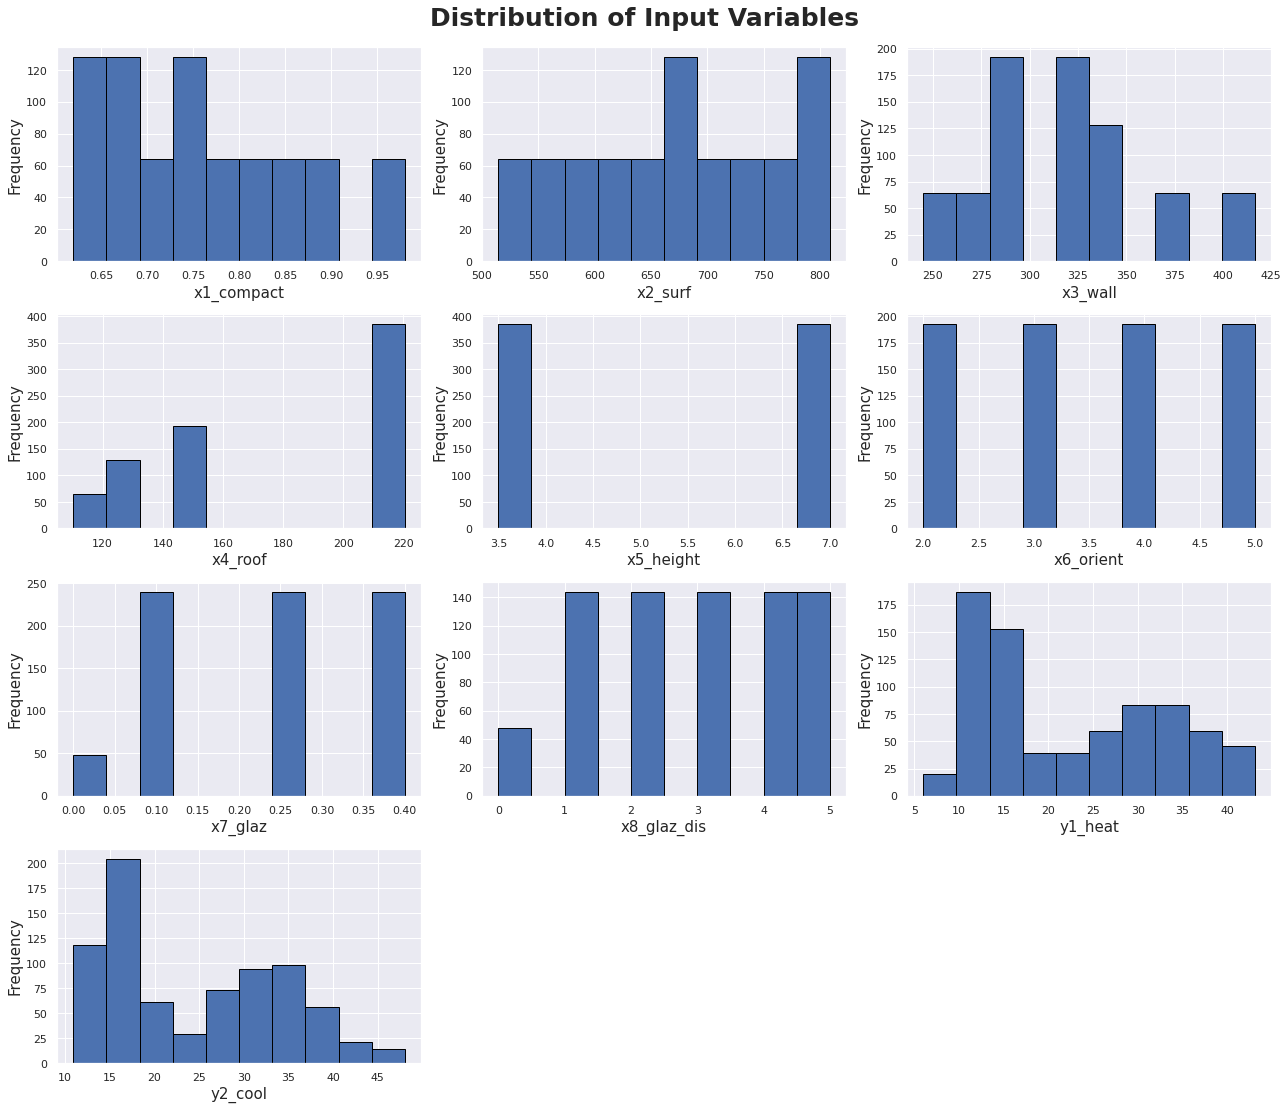

In [6]:
histplot(data=df)

### Scatter plotting
- **input variables ไม่มีความสัมพันธ์แบบเส้นตรงกับค่าพลังงาน(heating load and cooling load)**

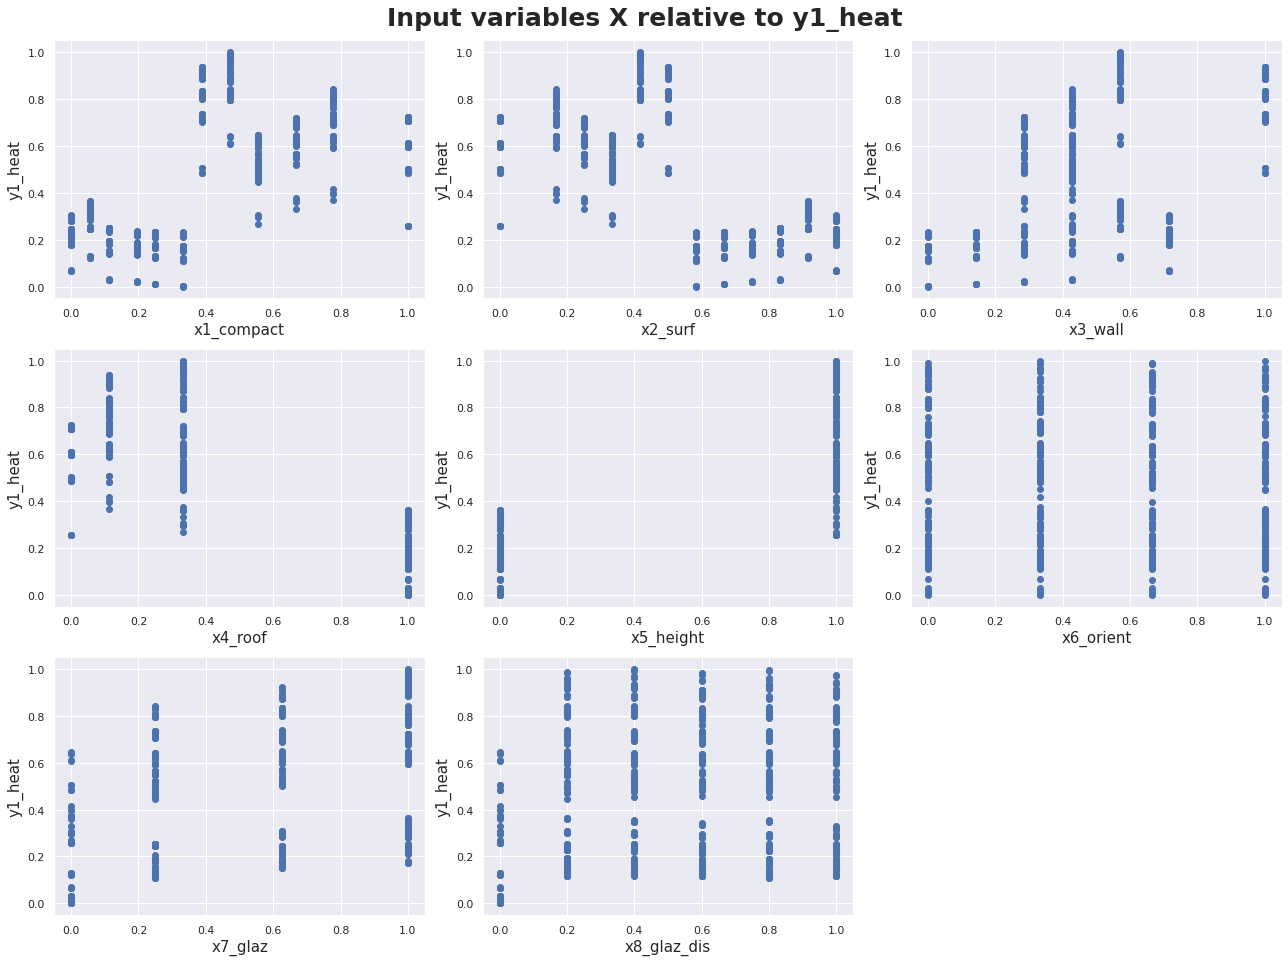

In [7]:
scatterplot(x=df.iloc[:,:-2], y=df.iloc[:,-2])

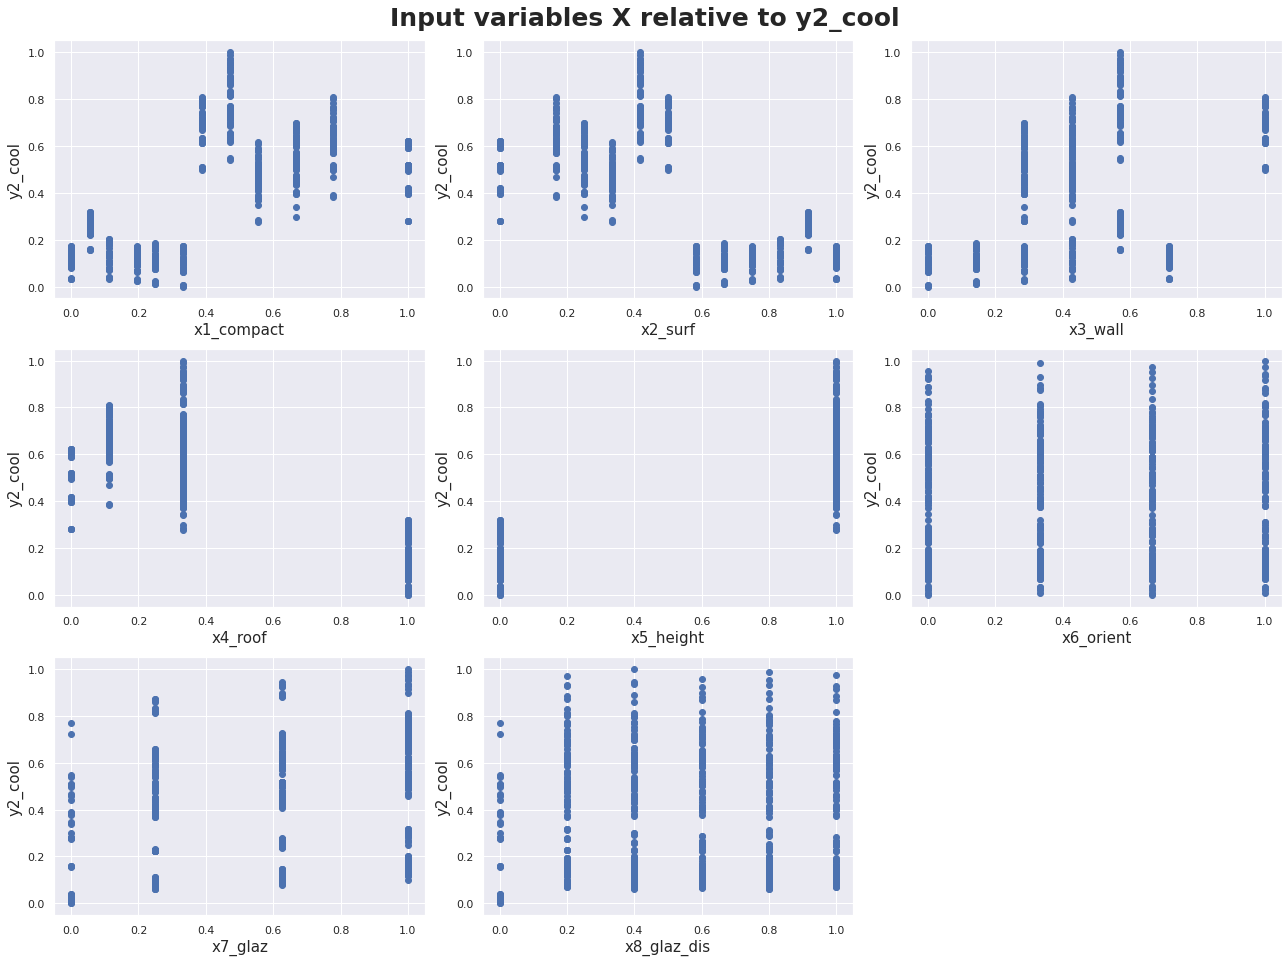

In [8]:
scatterplot(x=df.iloc[:,:-2], y=df.iloc[:,-1])

## Spearman Rank Correlation 
- จากการดูกราฟ histogram, scatter ทำให้เห็นว่าไม่สามารถใช้ pearson's correlation ในการหาความสัมพนธ์ของตัวแปรได้เพราะ  
    1. not normal distribution
    2. discrete numerical value
    3. no linear relationship 
    
    
- จึงใช้ spearman rank correlation เพื่อหาความสัมพันธ์ของตัวแปร

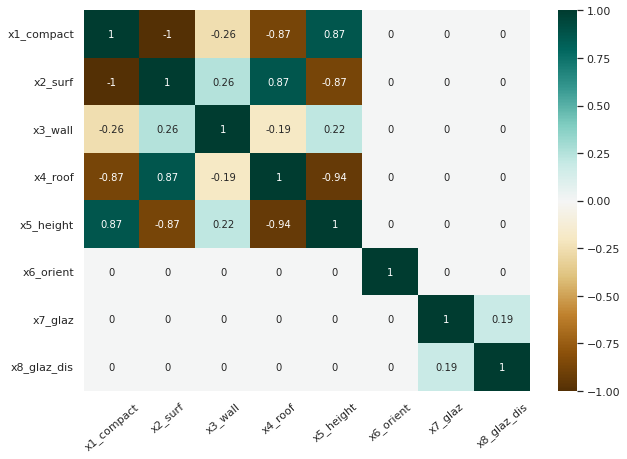

In [9]:
# Spearman Rank Correlation of input variables:
plt.figure(figsize=(10,7))
df_corr = df.corr('spearman').iloc[:-2, :-2].round(3)
ax = sns.heatmap(df_corr, vmin=-1, vmax=1, cmap='BrBG', annot=True)
ax.set_xticklabels(df_corr.columns,rotation=40)
plt.show()

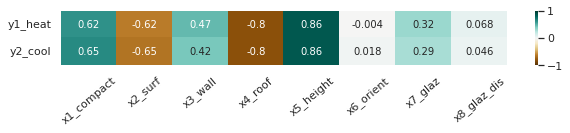

In [10]:
# Spearman Rank Correlation of input variables:
plt.figure(figsize=(10,1))
df_corr = df.corr('spearman').iloc[-2:,:-2].round(3)
ax = sns.heatmap(df_corr, vmin=-1, vmax=1, cmap='BrBG', annot=True)
ax.set_xticklabels(df_corr.columns,rotation=40)
plt.show()

#### Input variables correlation 
- เนื่องจากX1 หรือRelative Compactness ค่าทางวิศวะโยธา(ขึ้นอยู่กับรูปร่างของตึก) แปรผกผันกับ X2 พื้นที่ผิวอาคาร ทำให้ค่าcorrelationเป็น -1 
- X4 correlateสูงกับค่าX5 แปรผกผัน -0.937


#### Correlation between Input variables and Y1 , Y2
- X5,X1 สัมพันธ์สูงในทาง ***บวก*** กับ Y1, Y2
- X4,X2 สัมพันธ์สูงในทาง ***ลบ*** กับ Y1, Y2

# Conclusion from EDA
หลังจากทำ Exploratory Data Analysis ได้ข้อสรุปว่า linear regression อาจจะไม่เหมาะกับข้อมูลนี้เพราะ

1. ข้อมูลไม่มีการกระจายตัวแบบ normal distribution
2. บางfeature ถึงแม้จะเป็นตัวเลข แต่ก็เป็น discrete
3. ตัวแปรต้น X ไม่มีความสัมพันธ์ในเชิงเส้นตรงกับ Y1, Y2 linear relationship

# Conclusion from Correlation Analysis
1. Dropping columns that have weak correlation with y1 and y2
  - x_6_orient
  - x8_galz_dis
2. Dropping columns that are redundant in input variables
  - x1_compact and x2_surf have very high correlation to each other. And have exactly the same correlation score to y1 and y2. 
  - So we will drop x1_compact and use x2_surf instead 


In [11]:
# Select features from correlation analysis
colX = ['x2_surf', 'x3_wall', 'x4_roof', 'x5_height', 'x7_glaz']
x = df.loc[:, colX]
y1 = df.loc[:, 'y1_heat']
y2 = df.loc[:, 'y2_cool']

In [12]:
models = [Pipeline([('scaler', MinMaxScaler()),('mlr', LinearRegression())]),
          KNeighborsRegressor(n_neighbors=3),
          KNeighborsRegressor(n_neighbors=5),
          KNeighborsRegressor(n_neighbors=7),
          Pipeline([('scaler', MinMaxScaler()),('svr', SVR(kernel='rbf'))]),
          Pipeline([('scaler', MinMaxScaler()),
                    ('mlp', MLPRegressor((100,100), random_state=42, max_iter=500))]),
          RandomForestRegressor(),
          ExtraTreesRegressor(),
          GradientBoostingRegressor()]

model_names=['MLR', 'kNN3', 'kNN5', 'kNN7', 'SVR', 'MLP', 'RF', 'ET', 'GBM']

In [13]:
def model_perfomance(models, model_names, x, y):
  r2_train, mae_train, mse_train = dict(), dict(), dict()
  r2_valid, mae_valid, mse_valid = dict(), dict(), dict()

  for model, name in zip(models, model_names):
    scores = cross_validate(model, x, y1, cv=5, scoring=('r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_error'), return_train_score=True)
    r2_train[name] = scores['train_r2']
    mae_train[name] = scores['train_neg_mean_absolute_error']
    mse_train[name] = scores['train_neg_root_mean_squared_error']
    r2_valid[name] = scores['test_r2']
    mae_valid[name] = scores['test_neg_mean_absolute_error']
    mse_valid[name] = scores['test_neg_root_mean_squared_error']

  train_score = pd.concat([
                           pd.DataFrame(r2_train, index=pd.MultiIndex.from_tuples([('R-squared', f'cv{i}') for i in range(1,6)])).T,
                           pd.DataFrame(mae_train, index=pd.MultiIndex.from_tuples([('MAE', f'cv{i}') for i in range(1,6)])).T,
                           pd.DataFrame(mse_train, index=pd.MultiIndex.from_tuples([('RMSE', f'cv{i}') for i in range(1,6)])).T
                           ], axis=1).round(2)

  valid_score = pd.concat([
                          pd.DataFrame(r2_valid, index=pd.MultiIndex.from_tuples([('R-squared', f'cv{i}') for i in range(1,6)])).T,
                          pd.DataFrame(mae_valid, index=pd.MultiIndex.from_tuples([('MAE', f'cv{i}') for i in range(1,6)])).T,
                          pd.DataFrame(mse_valid, index=pd.MultiIndex.from_tuples([('RMSE', f'cv{i}') for i in range(1,6)])).T
                          ], axis=1).round(2)

  
  return train_score, valid_score

In [14]:
train_score_y1, valid_score_y1 = model_perfomance(models, model_names, x, y1)
train_score_y2, valid_score_y2 = model_perfomance(models, model_names, x, y2)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


# Results from 6 based models

### Y1 on Training and Testing sets

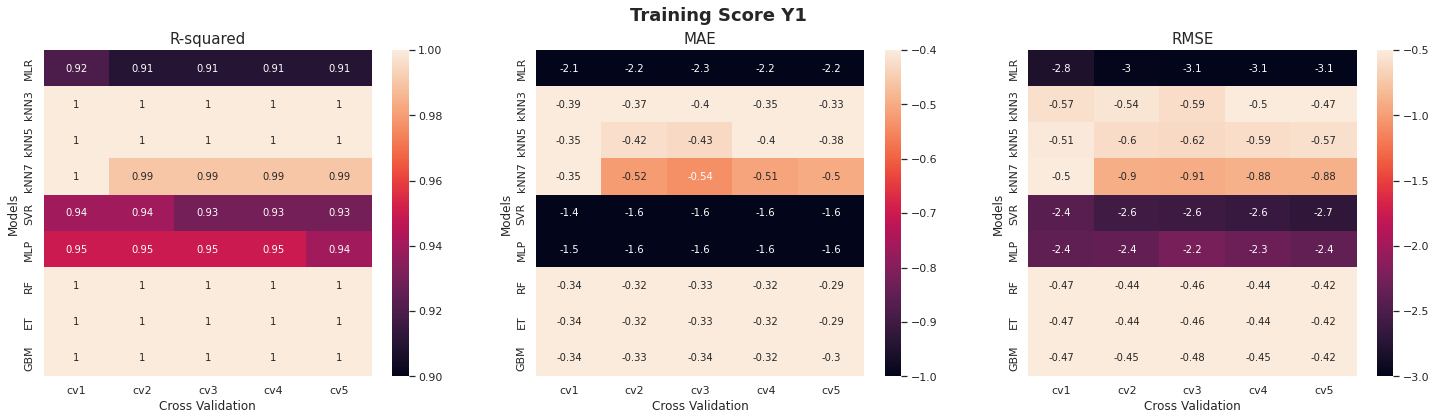

In [15]:
fig, axes = plt.subplots(1,3, figsize=(25, 6))
sns.heatmap(train_score_y1['R-squared'], annot=True, ax=axes[0], vmin=.9, vmax=1)
sns.heatmap(train_score_y1['MAE'], annot=True, ax=axes[1], vmin=-1, vmax=-0.4)
sns.heatmap(train_score_y1['RMSE'], annot=True, ax=axes[2], vmin=-3, vmax=-0.5)
for i, metric in enumerate(['R-squared', 'MAE', 'RMSE']):
  axes[i].set_xlabel('Cross Validation')
  axes[i].set_ylabel('Models')
  axes[i].set_title(metric, fontsize=15)
fig.suptitle('Training Score Y1', fontsize=18, weight='bold')
plt.show()

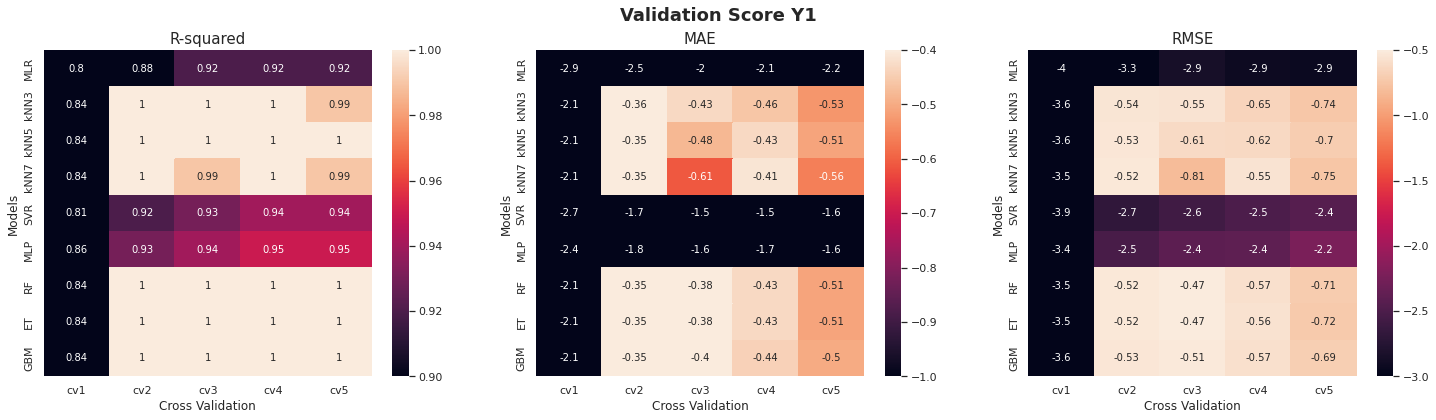

In [16]:
fig, axes = plt.subplots(1,3, figsize=(25, 6))
sns.heatmap(valid_score_y1['R-squared'], annot=True, ax=axes[0], vmin=.9, vmax=1)
sns.heatmap(valid_score_y1['MAE'], annot=True, ax=axes[1], vmin=-1, vmax=-0.4)
sns.heatmap(valid_score_y1[ 'RMSE'], annot=True, ax=axes[2], vmin=-3, vmax=-0.5)
for i, metric in enumerate(['R-squared', 'MAE', 'RMSE']):
  axes[i].set_xlabel('Cross Validation')
  axes[i].set_ylabel('Models')
  axes[i].set_title(metric, fontsize=15)
fig.suptitle('Validation Score Y1', fontsize=18, weight='bold')
plt.show()

### Y2 on Training and Testing sets

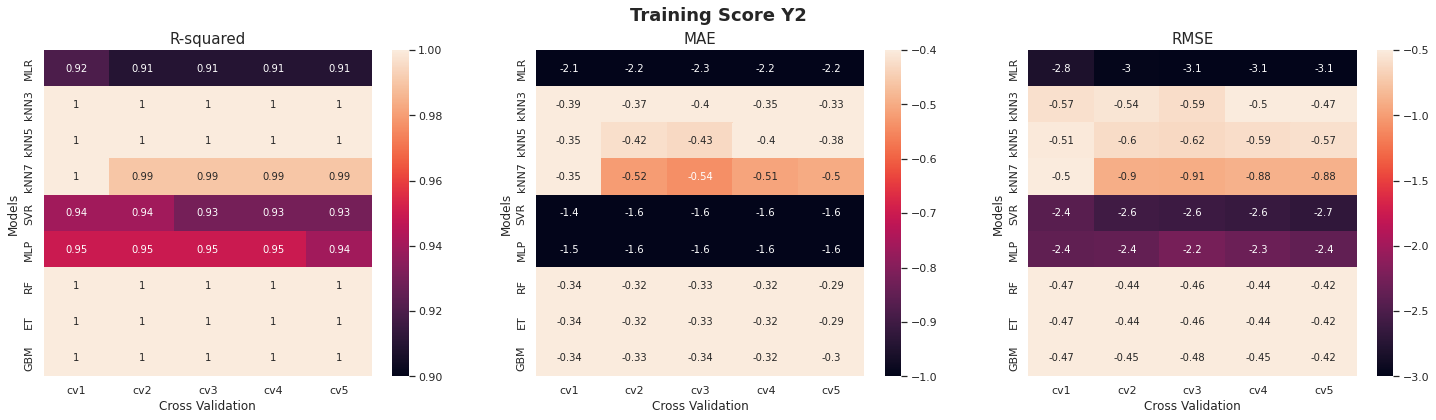

In [17]:
fig, axes = plt.subplots(1,3, figsize=(25, 6))
sns.heatmap(train_score_y2['R-squared'], annot=True, ax=axes[0], vmin=.9, vmax=1)
sns.heatmap(train_score_y2['MAE'], annot=True, ax=axes[1], vmin=-1, vmax=-0.4)
sns.heatmap(train_score_y2[ 'RMSE'], annot=True, ax=axes[2], vmin=-3, vmax=-0.5)
for i, metric in enumerate(['R-squared', 'MAE', 'RMSE']):
  axes[i].set_xlabel('Cross Validation')
  axes[i].set_ylabel('Models')
  axes[i].set_title(metric, fontsize=15)
fig.suptitle('Training Score Y2', fontsize=18, weight='bold')
plt.show()

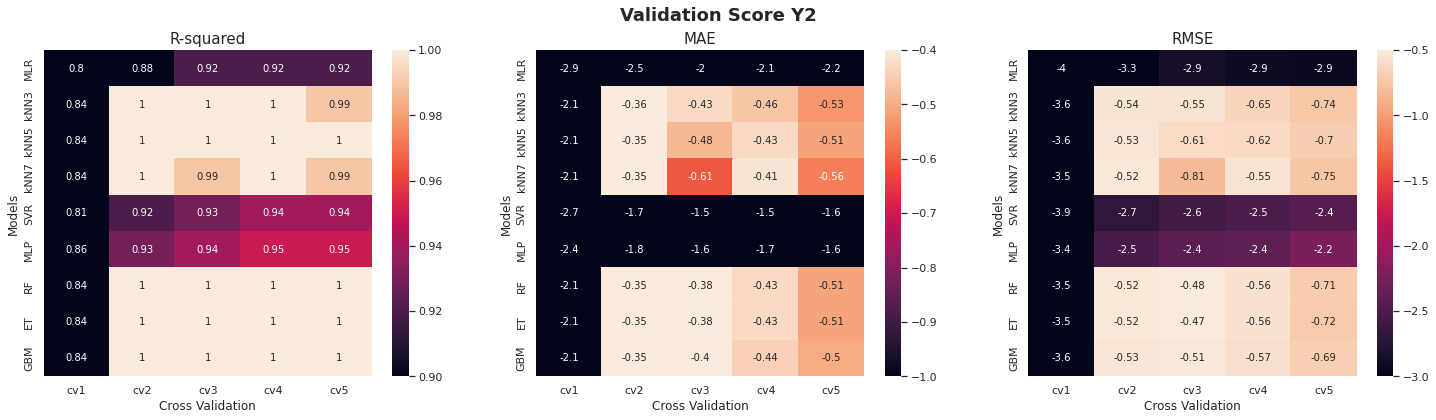

In [18]:
fig, axes = plt.subplots(1,3, figsize=(25, 6))
sns.heatmap(valid_score_y2['R-squared'], annot=True, ax=axes[0], vmin=.9, vmax=1)
sns.heatmap(valid_score_y2['MAE'], annot=True, ax=axes[1], vmin=-1, vmax=-0.4)
sns.heatmap(valid_score_y2[ 'RMSE'], annot=True, ax=axes[2], vmin=-3, vmax=-0.5)
for i, metric in enumerate(['R-squared', 'MAE', 'RMSE']):
  axes[i].set_xlabel('Cross Validation')
  axes[i].set_ylabel('Models')
  axes[i].set_title(metric, fontsize=15)
fig.suptitle('Validation Score Y2', fontsize=18, weight='bold')
plt.show()

# **Which metric is better?**

1. There are 3 metrics R-suquared, MAE, RMSE ==> 
  - MSE and RMSE penalizes the large predictions errors because of "square". RMSE is widely used than MSE to evaluate the perfomance of the regression model with other random models as it has the same units (scaled y)
  - For comparing the accuracy among differnet linear regression models, RMSE is a better choice 
  - MAE is easier to interpret, rosuct to outliers
  - R2, Adjust R2 are used for explaining how well the independent variables (x) in the linear regression model explains the variability in the dependent variable (y). 
  - R2 value always increases with the addition of the independent variables which might lead to the addition of the redundant variables in our model.
  - Adjust R2 is used to determine the number of independent variables in our model. Adjust R2 decreases if the increase in R2 by the additional variable isn't significant enough.

2. Use **RMSE** to compare the prediction accuracy
  -


In [19]:
print('Mean RMSE cross validation on Y1 validation set:')
np.mean(valid_score_y1['RMSE'], axis=1).sort_values(ascending=False)

Mean RMSE cross validation on Y1 validation set:


ET     -1.164
RF     -1.164
GBM    -1.172
kNN5   -1.208
kNN3   -1.210
kNN7   -1.234
MLP    -2.580
SVR    -2.828
MLR    -3.190
dtype: float64

In [20]:
print('Mean RMSE cross validation on Y2 validation set:')
np.mean(valid_score_y2['RMSE'], axis=1).sort_values(ascending=False)

Mean RMSE cross validation on Y2 validation set:


ET     -1.164
RF     -1.164
GBM    -1.172
kNN5   -1.208
kNN3   -1.210
kNN7   -1.234
MLP    -2.580
SVR    -2.828
MLR    -3.190
dtype: float64

### **Extra Tree VS Random Forest**
- trees ensemble methods are better than simple decision trees
- Random forest uses bootstrap replicas, that is to say, it subsamples the input data with replacement, whereas Extra Trees use the whole original sample
- Another difference is the selection of cut points in order to split nodes. Random Forest chooses the optimum split while Extra Trees chooses it randomly. However, once the split points are selected, the two algorithms choose the best one between all the subset of features. Therefore, Extra Trees adds randomization but still has optimization.

It is worth noting the difference in the execution time, where the Extra Trees is much faster. Therefore, if you have any doubt about which of the two ensembles to use, **it seems a good idea to use Extra Trees since the same result is obtained in a faster way.**

# **Conclusion**

### Extra Tree ให้ผลลัพธ์ที่ใกล้เคียงกับ Random Forest แต่ใช้เวลาในการtrainingที่น้อยกว่า ดังนั้นจึงควรใช้ Extra Tree 

# Support Vector Machine Hyperparameter Tuning (For Fun !!!)

กำหนดค่า C, gamma ที่ต้องการจะหา ที่ทำให้ค่า evaluation metrics น้อยที่สุด ซึ่งเราใช้ Mean Squared Error (MSE) แต่ในการเขียนโค้ดคำนวณถ้าเราจะใช้ 'mean_squared_error' ให้เพิ่ม 'neg_mean_squared_error' 

เราสามารถสร้าง pipeline หลายๆอันสำหรับคอลัมน์ Numerical หรือ Categorical ได้โดยใช้ `sklearn.pipeline.make_pipeline` แล้วนำ pipeline หลายๆอันนั้นมาประกอบใน `sklearn.compose.make_column_transformer` ดูpipelineได้จาก

```
from sklearn import set_config
set_config(display='diagram')
pipeline

```

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
def svr_tuning(x,y):
  scores = dict()
  best_param = dict()
  best_rmse = dict()
  # Set params for large
  C = [0.01, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000]
  gamma =[0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
  for scale in ['large', 'medium', 'fine', 'super_fine']:
    print(scale.upper() + ' Scale GridSearch')
    print(f'C: {C} \ngamma: {gamma} \n')
    
    # --------------------------Set pipeline process--------------------------
    pipe = Pipeline([('scaling', StandardScaler()),
                  ('svr', SVR('rbf'))])
    param = {'svr__gamma':gamma, 'svr__C': C}

    # --------------------------GridSearch--------------------------
    best_model = GridSearchCV(pipe, param, 
                              scoring='neg_root_mean_squared_error', cv=5, verbose = True, n_jobs=-1)
    best_model.fit(x,y)
    print('Training Finished')
    
    # --------------------------Save best_model--------------------------
    joblib.dump(best_model, '/content/drive/MyDrive/Colab Notebooks/Self Study/model/best_model_'+ scale +'_'+ y.name +'.pkl')
    print('Saved\n')

    # --------------------------Collect scores, best_params into the dictionary--------------------------
    scores[scale] = pd.DataFrame(best_model.cv_results_['mean_test_score'].reshape(len(C),len(gamma)),
                                index = C, columns = gamma)
    best_param[scale] = best_model.best_params_
    best_rmse[scale] = np.around(best_model.best_score_, 4)
    
    #--------------------------Find C, gamma near best_C, best_gamma--------------------------
    best_C = best_model.best_params_['svr__C']
    best_gamma = best_model.best_params_['svr__gamma']
    
    i_best_C = C.index(best_C)
    i_best_gamma = gamma.index(best_gamma)

    try:
      left_C, left_gamma = C[i_best_C-1], gamma[i_best_gamma-1]
      right_C, right_gamma = C[i_best_C+1], gamma[i_best_gamma+1]
    except IndexError:
      left_C, left_gamma = best_C*0.95, best_gamma*0.95
      right_C, right_gamma = best_C*1.05, best_gamma*1.05

    #--------------------------Update finer params from best params--------------------------
    best_C = best_model.best_params_['svr__C']
    best_gamma = best_model.best_params_['svr__gamma']
    C = np.around(np.concatenate([np.linspace(left_C, best_C, 5, endpoint=False),
                             np.linspace(best_C, right_C, 5)]), 2).tolist()
    gamma = np.around(np.concatenate([np.linspace(left_gamma, best_gamma, 5, endpoint=False),
                             np.linspace(best_gamma, right_gamma, 5)]), 6).tolist()
    print(scale.upper() + ' Scale GridSearch Results:')
    print('Best RMSE Score: ' + str(np.around(abs(best_model.best_score_),4)))
    print('Best Parameters: (C: {}), (gamma:{})'.format(best_C, best_gamma))
    print('-'*80, '\n')
  
  #--------------------------Save scores and best_params dictionaries--------------------------
  with open('/content/drive/MyDrive/Colab Notebooks/Self Study/results/best_param_'+ y.name + '.pkl', 'wb') as f:
    pickle.dump(best_param, f)
  with open('/content/drive/MyDrive/Colab Notebooks/Self Study/results/scores_'+ y.name +'.csv', 'wb') as f:
    pickle.dump(scores, f)    
  return best_model, scores, best_param, best_rmse

In [31]:
colX = ['x2_surf', 'x3_wall', 'x4_roof', 'x5_height', 'x7_glaz']
x = df.loc[:, colX]
y1 = df.loc[:, 'y1_heat']
y2 = df.loc[:, 'y2_cool']

### SVR Tuning for Y1

In [32]:
best_model_y1, scores_y1, best_param_y1, best_rmse_y1 = svr_tuning(x=x,y=y1)

LARGE Scale GridSearch
C: [0.01, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000] 
gamma: [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000] 

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  6.0min finished


Training Finished
Saved

LARGE Scale GridSearch Results:
Best RMSE Score: 0.795
Best Parameters: (C: 100000), (gamma:0.1)
-------------------------------------------------------------------------------- 

MEDIUM Scale GridSearch
C: [10000.0, 28000.0, 46000.0, 64000.0, 82000.0, 100000.0, 325000.0, 550000.0, 775000.0, 1000000.0] 
gamma: [0.01, 0.028, 0.046, 0.064, 0.082, 0.1, 0.325, 0.55, 0.775, 1.0] 

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 121 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 371 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  9.2min finished


Training Finished
Saved

MEDIUM Scale GridSearch Results:
Best RMSE Score: 0.7603
Best Parameters: (C: 100000.0), (gamma:0.082)
-------------------------------------------------------------------------------- 

FINE Scale GridSearch
C: [82000.0, 85600.0, 89200.0, 92800.0, 96400.0, 100000.0, 156250.0, 212500.0, 268750.0, 325000.0] 
gamma: [0.064, 0.0676, 0.0712, 0.0748, 0.0784, 0.082, 0.0865, 0.091, 0.0955, 0.1] 

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 370 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  8.6min finished


Training Finished
Saved

FINE Scale GridSearch Results:
Best RMSE Score: 0.7179
Best Parameters: (C: 325000.0), (gamma:0.0676)
-------------------------------------------------------------------------------- 

SUPER_FINE Scale GridSearch
C: [308750.0, 312000.0, 315250.0, 318500.0, 321750.0, 325000.0, 329062.5, 333125.0, 337187.5, 341250.0] 
gamma: [0.06422, 0.064896, 0.065572, 0.066248, 0.066924, 0.0676, 0.068445, 0.06929, 0.070135, 0.07098] 

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 370 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 21.0min finished


Training Finished
Saved

SUPER_FINE Scale GridSearch Results:
Best RMSE Score: 0.717
Best Parameters: (C: 333125.0), (gamma:0.0676)
-------------------------------------------------------------------------------- 



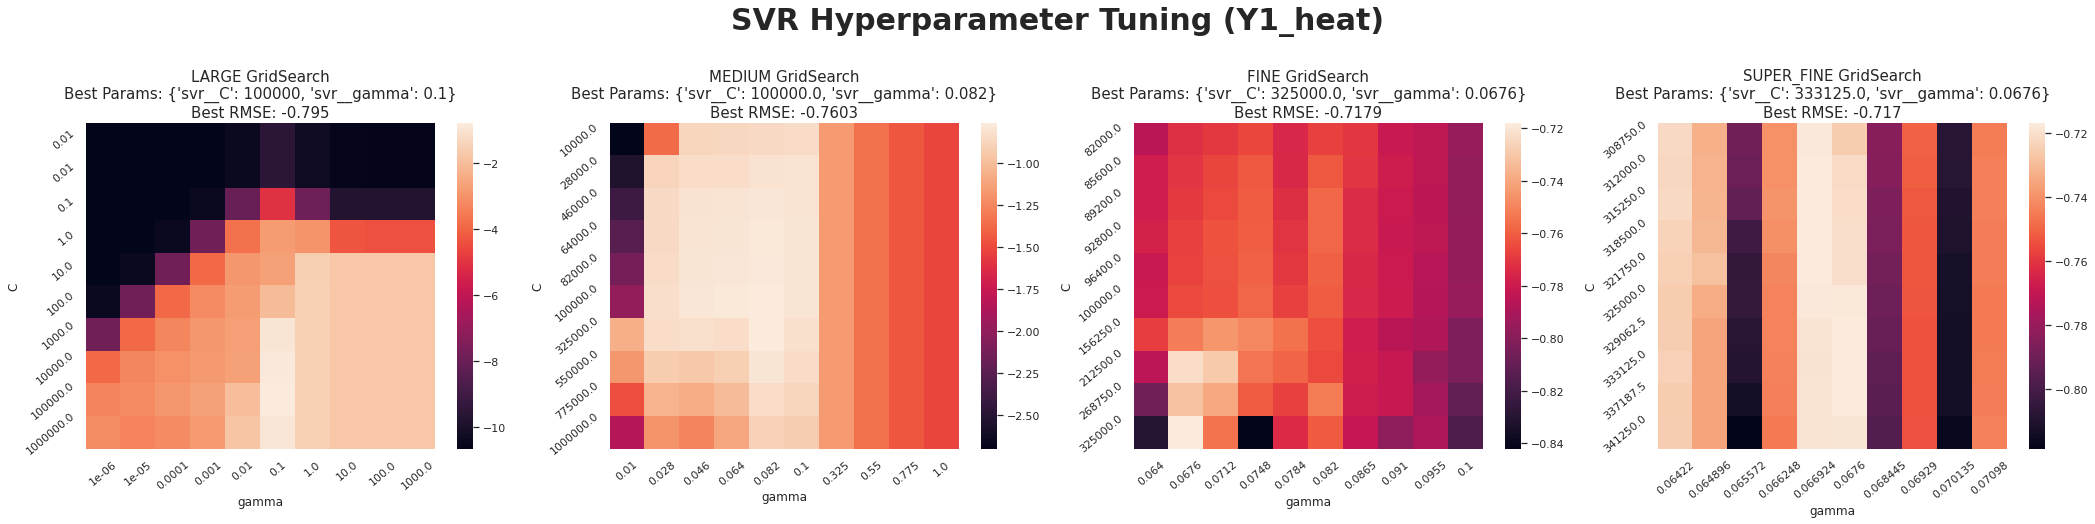

In [33]:
fig, axes = plt.subplots(1,4, figsize=(36, 6))
sns.heatmap(scores_y1['large'], ax=axes[0]) #vmin=0, vmax=1
sns.heatmap(scores_y1['medium'], ax=axes[1]) #vmin=0, vmax=1
sns.heatmap(scores_y1['fine'], ax=axes[2]) #vmin=0, vmax=1
sns.heatmap(scores_y1['super_fine'], ax=axes[3]) #vmin=0, vmax=1
for i, scale in enumerate(['large', 'medium', 'fine', 'super_fine']):
  axes[i].set_xlabel('gamma')
  axes[i].set_ylabel('C')
  axes[i].set_xticklabels(scores_y1[scale].columns, rotation=40)
  axes[i].set_yticklabels(scores_y1[scale].index, rotation=40)
  axes[i].set_title('{} GridSearch\nBest Params: {}\nBest RMSE: {}'.format(
      scale.upper(), best_param_y1[scale], best_rmse_y1[scale]), fontsize=15)

fig.suptitle('SVR Hyperparameter Tuning (Y1_heat)', fontsize=30, y=1.15, weight='bold')
plt.show()

###SVR Tuning for Y2

In [34]:
best_model_y2, scores_y2, best_param_y2, best_rmse_y2 = svr_tuning(x=x,y=y2)

LARGE Scale GridSearch
C: [0.01, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000] 
gamma: [1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000] 

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 421 out of 500 | elapsed:    1.3s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  2.0min finished


Training Finished
Saved

LARGE Scale GridSearch Results:
Best RMSE Score: 1.9008
Best Parameters: (C: 100000), (gamma:0.1)
-------------------------------------------------------------------------------- 

MEDIUM Scale GridSearch
C: [10000.0, 28000.0, 46000.0, 64000.0, 82000.0, 100000.0, 325000.0, 550000.0, 775000.0, 1000000.0] 
gamma: [0.01, 0.028, 0.046, 0.064, 0.082, 0.1, 0.325, 0.55, 0.775, 1.0] 

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 421 out of 500 | elapsed:  1.6min remaining:   18.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.2min finished


Training Finished
Saved

MEDIUM Scale GridSearch Results:
Best RMSE Score: 1.8752
Best Parameters: (C: 550000.0), (gamma:0.082)
-------------------------------------------------------------------------------- 

FINE Scale GridSearch
C: [325000.0, 370000.0, 415000.0, 460000.0, 505000.0, 550000.0, 606250.0, 662500.0, 718750.0, 775000.0] 
gamma: [0.064, 0.0676, 0.0712, 0.0748, 0.0784, 0.082, 0.0865, 0.091, 0.0955, 0.1] 

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 370 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 12.9min finished


Training Finished
Saved

FINE Scale GridSearch Results:
Best RMSE Score: 1.87
Best Parameters: (C: 325000.0), (gamma:0.0748)
-------------------------------------------------------------------------------- 

SUPER_FINE Scale GridSearch
C: [775000.0, 685000.0, 595000.0, 505000.0, 415000.0, 325000.0, 336250.0, 347500.0, 358750.0, 370000.0] 
gamma: [0.0712, 0.07192, 0.07264, 0.07336, 0.07408, 0.0748, 0.0757, 0.0766, 0.0775, 0.0784] 

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 370 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 10.7min finished


Training Finished
Saved

SUPER_FINE Scale GridSearch Results:
Best RMSE Score: 1.8691
Best Parameters: (C: 347500.0), (gamma:0.0748)
-------------------------------------------------------------------------------- 



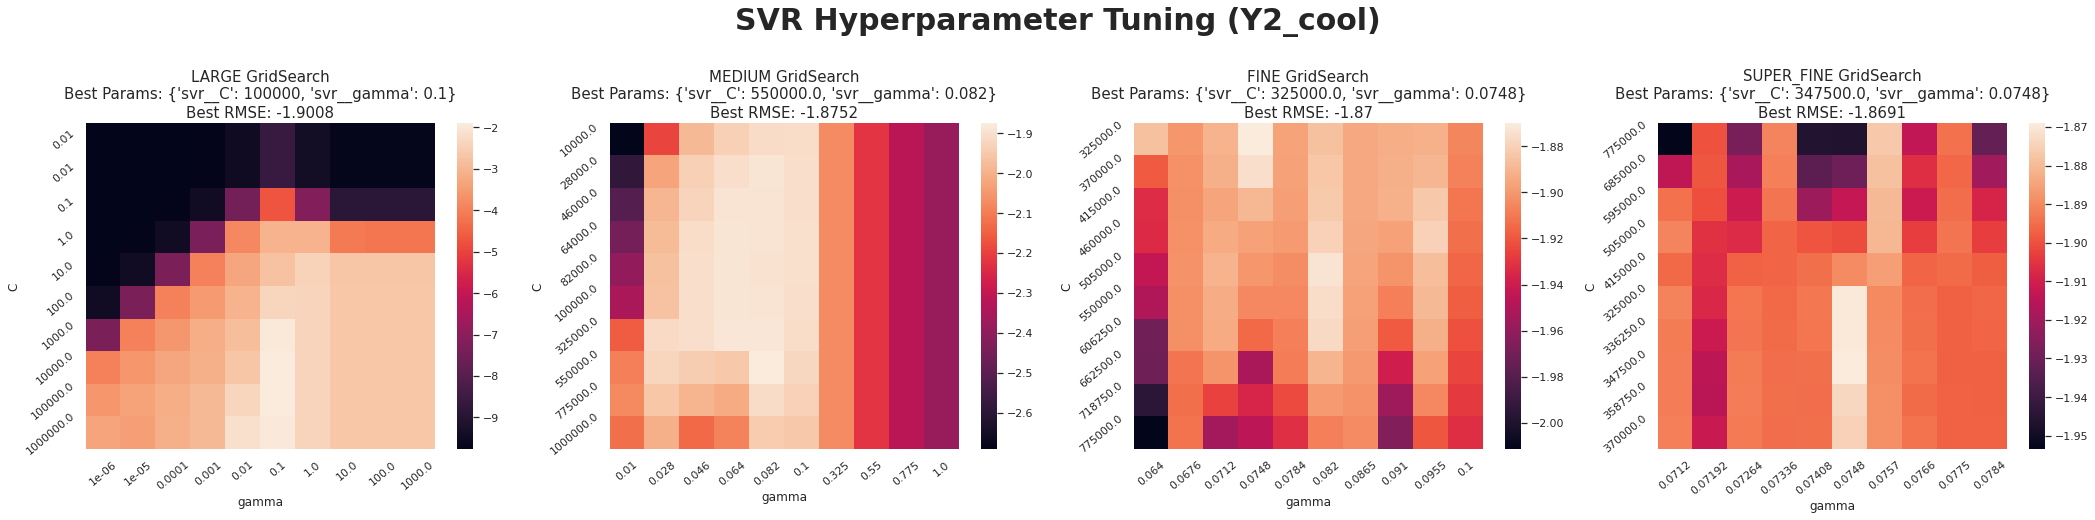

In [35]:
fig, axes = plt.subplots(1,4, figsize=(36, 6))
sns.heatmap(scores_y2['large'], ax=axes[0]) #vmin=0, vmax=1
sns.heatmap(scores_y2['medium'], ax=axes[1]) #vmin=0, vmax=1
sns.heatmap(scores_y2['fine'], ax=axes[2]) #vmin=0, vmax=1
sns.heatmap(scores_y2['super_fine'], ax=axes[3]) #vmin=0, vmax=1
for i, scale in enumerate(['large', 'medium', 'fine', 'super_fine']):
  axes[i].set_xlabel('gamma')
  axes[i].set_ylabel('C')
  axes[i].set_xticklabels(scores_y2[scale].columns, rotation=40)
  axes[i].set_yticklabels(scores_y2[scale].index, rotation=40)
  axes[i].set_title('{} GridSearch\nBest Params: {}\nBest RMSE: {}'.format(
      scale.upper(), best_param_y2[scale], best_rmse_y2[scale]), fontsize=15)

fig.suptitle('SVR Hyperparameter Tuning (Y2_cool)', fontsize=30, y=1.15, weight='bold')
plt.show()